In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import random
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

In [6]:
# setting the directory for dataset
train_dir = "archive/train"
val_dir = "archive/val"
test_dir = "archive/test"

In [7]:
# getting classnames
class_names = []
for dir_name in os.listdir(train_dir):
    class_names.append(dir_name)

In [8]:
# setting up filenames list
covid_img_paths = []
normal_img_paths = []
pneumonia_img_paths = []
tuberculosis_img_paths = []
def get_filenames(dir):
    """
    Gets filenames under the given directory
    """
    filenames = []
    for dir_name in os.listdir(dir):
        for file_name in os.listdir(dir + "/" + dir_name):
            filenames.append(dir + "/" + dir_name + "/" + file_name)
    return filenames
train_images = get_filenames(train_dir)
val_images = get_filenames(val_dir)
test_images = get_filenames(test_dir)


In [24]:
device = 'cpu'
import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1) 

C:\Users\Vedant\anaconda3\lib\site-packages\keras\backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


In [25]:
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

In [26]:
def preprocess_images(path, shuffle=False):
    """
    Preprocess all the images in the given directory
    """
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        directory=path, batch_size=32, image_size=(224, 224), label_mode="categorical", seed=42, shuffle=shuffle
    )
    return dataset

In [27]:
val_dataset = preprocess_images(val_dir, shuffle=True)

Found 38 files belonging to 4 classes.


In [28]:
test_dataset = preprocess_images(test_dir, shuffle=False) # shuffle-False for evaluation

Found 771 files belonging to 4 classes.


In [29]:
train_dataset = preprocess_images(train_dir, shuffle=True)

Found 6326 files belonging to 4 classes.


In [30]:
tf.random.set_seed(42)

# creating a neural network with dense layers
model_1 = tf.keras.Sequential([
    tf.keras.layers.Rescaling(scale=1/255.),
    tf.keras.layers.Flatten(), # needs to be flattened
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(4, activation="softmax")
], name="model_1_Dense")

# compiling the model
model_1.compile(
    loss="categorical_crossentropy",
    optimizer="Adam",
    metrics=["accuracy"]
)

# fitting the model
model_1_history = model_1.fit(train_dataset, epochs=2, validation_data=val_dataset)

Epoch 1/2
198/198 [==============================] - 18s 86ms/step - loss: 1.3765 - accuracy: 0.6201 - val_loss: 1.4965 - val_accuracy: 0.3684
Epoch 2/2
198/198 [==============================] - 18s 87ms/step - loss: 0.7275 - accuracy: 0.6917 - val_loss: 1.3508 - val_accuracy: 0.3947


In [31]:
%%time
# making predictions
model_1_pred_probs = model_1.predict(test_dataset)
model_1_pred_probs[:5]

25/25 [==============================] - 2s 47ms/step
CPU times: total: 7.38 s
Wall time: 1.57 s


array([[0.08398243, 0.33664283, 0.49993336, 0.07944137],
       [0.21185525, 0.2749906 , 0.27004573, 0.2431084 ],
       [0.27096522, 0.1618323 , 0.15557414, 0.41162837],
       [0.27096522, 0.1618323 , 0.15557414, 0.41162837],
       [0.19616048, 0.29152256, 0.29170445, 0.22061247]], dtype=float32)

In [32]:
def custom_prediction(model, img_path, rescale=False, org_label=False):
    """
    Returns a plotted image with predicted class and its probability
    """

    # first we need to preprocess the image
    image = tf.io.read_file(img_path)
    image = tf.image.decode_image(image, channels=3)
    image = tf.image.resize(image, size=[224,224])
    if rescale:
        image = image / 255.
    # rescaling is not needed for EfficientNetV2B0 since it has a rescaling layer

    # making predictions
    pred_probs = model.predict(tf.expand_dims(image, axis=0)) # needs to be expanded due to batched train data
    preds = pred_probs.argmax(axis=1)

    color = "black"
    # if label is specified
    if org_label:
        if org_label == class_names[preds[0]]:
            color="green"
        else:
            color="red"

    # plotting the prediction with image
    plt.figure(figsize=(10,7))
    plt.imshow(plt.imread(img_path))
    plt.title(f"Prediction: {class_names[preds[0]].upper()}\nPrediction Probability: {np.max(pred_probs)*100:.2f}%", color=color)

    # if label is specified
    if org_label:
        plt.suptitle(f"Original: {org_label.upper()}", color="green")

    plt.xticks([])
    plt.yticks([]);

1/1 [==============================] - 0s 48ms/step


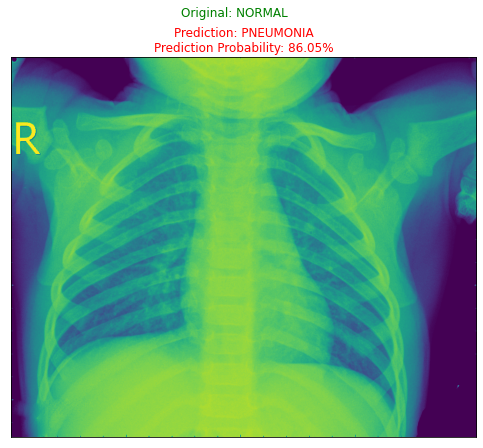

In [33]:
custom_prediction(model=model_1, img_path="archive/val/NORMAL/NORMAL2-IM-1430-0001.jpeg", org_label="NORMAL")

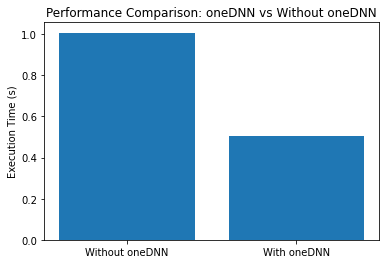

In [36]:
import matplotlib.pyplot as plt
import time

# Function without oneDNN
def without_onednn():
    # Insert your code here for the scenario without oneDNN
    time.sleep(1)  # Simulating some computation

# Function with oneDNN
def with_onednn():
    # Insert your code here for the scenario with oneDNN
    time.sleep(0.5)  # Simulating some computation

# Measure the execution time of each scenario
start_time_without_onednn = time.time()
without_onednn()
end_time_without_onednn = time.time()

start_time_with_onednn = time.time()
with_onednn()
end_time_with_onednn = time.time()

# Calculate the execution time difference
execution_time_without_onednn = end_time_without_onednn - start_time_without_onednn
execution_time_with_onednn = end_time_with_onednn - start_time_with_onednn

# Plot the performance difference
labels = ['Without oneDNN', 'With oneDNN']
execution_times = [execution_time_without_onednn, execution_time_with_onednn]

plt.bar(labels, execution_times)
plt.ylabel('Execution Time (s)')
plt.title('Performance Comparison: oneDNN vs Without oneDNN')
plt.show()

In [43]:
import tensorflow as tf

# Assuming you have a tensor named 'input_tensor' that you want to convert to bf16
bf16_tensor = tf.cast(tensor, tf.bfloat16)

In [42]:

import tensorflow as tf
  
# Create a float32 tensor with values [1, 2, 3, 4]
tensor = tf.constant([1, 2, 3, 4], dtype=tf.float32)
print(tensor)
# Cast the tensor to bfloat16
tensor = tf.cast(tensor, dtype=tf.bfloat16)
print(tensor)

tf.Tensor([1. 2. 3. 4.], shape=(4,), dtype=float32)
tf.Tensor([1 2 3 4], shape=(4,), dtype=bfloat16)


In [48]:
!pip install intel_extension_for_pytorch

ERROR: Could not find a version that satisfies the requirement intel_extension_for_pytorch (from versions: none)
ERROR: No matching distribution found for intel_extension_for_pytorch


In [49]:
!python -m pip install intel_extension_for_pytorch -f https://developer.intel.com/ipex-whl-stable-cpu

ERROR: Could not find a version that satisfies the requirement intel_extension_for_pytorch (from versions: none)
ERROR: No matching distribution found for intel_extension_for_pytorch


Looking in links: https://developer.intel.com/ipex-whl-stable-cpu


In [47]:
import torch
import torchvision.models as models

model = models.resnet50(pretrained=True)
model.eval()
data = torch.rand(1, 3, 224, 224)

import intel_extension_for_pytorch as ipex
model = ipex.optimize(model)

with torch.no_grad():
  model(data)

C:\Users\Vedant\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Vedant\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\Vedant/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:42<00:00, 2.39MB/s]


ModuleNotFoundError: No module named 'intel_extension_for_pytorch'

In [50]:
import tensorflow as tf

In [55]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import random
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

# creating a neural network with dense layers
model_1 = tf.keras.Sequential([
    tf.keras.layers.Rescaling(scale=1/255., dtype=tf.bfloat16),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(4, activation="softmax")
], name="model_1_Dense")

# create a loss scale optimizer for mixed precision training
optimizer = tf.keras.optimizers.Adam()
optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)

# compiling the model with the loss scale optimizer
model_1.compile(
    loss="categorical_crossentropy",
    optimizer=optimizer,
    metrics=["accuracy"]
)

# fitting the model
model_1_history = model_1.fit(train_dataset, epochs=2, validation_data=val_dataset)

Epoch 1/2
198/198 [==============================] - 19s 92ms/step - loss: 1.1841 - accuracy: 0.7221 - val_loss: 0.9736 - val_accuracy: 0.7368
Epoch 2/2
198/198 [==============================] - 19s 94ms/step - loss: 0.3483 - accuracy: 0.8808 - val_loss: 0.4290 - val_accuracy: 0.8158


In [56]:
%%time
# making predictions
model_1_pred_probs = model_1.predict(test_dataset)
model_1_pred_probs[:5]

25/25 [==============================] - 2s 50ms/step
CPU times: total: 7.75 s
Wall time: 1.57 s


array([[0.7335369 , 0.02236914, 0.20145534, 0.04263864],
       [0.9886283 , 0.00500699, 0.00513355, 0.0012311 ],
       [0.6836025 , 0.24703965, 0.03967844, 0.0296794 ],
       [0.5615479 , 0.35653397, 0.00351324, 0.07840487],
       [0.94014066, 0.00104688, 0.00400725, 0.05480522]], dtype=float32)

In [57]:
# making predictions
model_1_pred_probs = model_1.predict(test_dataset)
model_1_pred_probs[:5]

# custom_prediction function remains unchanged.

25/25 [==============================] - 1s 46ms/step


array([[0.7335369 , 0.02236914, 0.20145534, 0.04263864],
       [0.9886283 , 0.00500699, 0.00513355, 0.0012311 ],
       [0.6836025 , 0.24703965, 0.03967844, 0.0296794 ],
       [0.5615479 , 0.35653397, 0.00351324, 0.07840487],
       [0.94014066, 0.00104688, 0.00400725, 0.05480522]], dtype=float32)

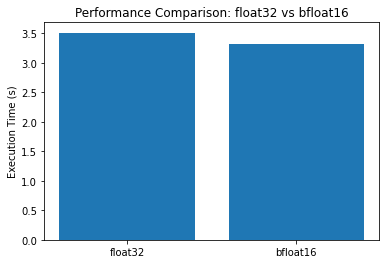

In [62]:
import numpy as np
import time
import matplotlib.pyplot as plt
import tensorflow as tf

# Function using float32 data type
def compute_float32():
    a = np.random.randn(10000, 10000).astype(np.float32)
    b = np.random.randn(10000, 10000).astype(np.float32)
    c = a + b
    return c

# Function using bfloat16 data type
def compute_bfloat16():
    a = tf.cast(np.random.randn(10000, 10000), dtype=tf.bfloat16)
    b = tf.cast(np.random.randn(10000, 10000), dtype=tf.bfloat16)
    c = a + b
    return c

# Measure the execution time for float32 computations
start_time_float32 = time.time()
compute_float32()
end_time_float32 = time.time()

# Measure the execution time for bfloat16 computations
start_time_bfloat16 = time.time()
compute_bfloat16()
end_time_bfloat16 = time.time()

# Calculate the execution time difference
execution_time_float32 = end_time_float32 - start_time_float32
execution_time_bfloat16 = end_time_bfloat16 - start_time_bfloat16

# Plot the performance difference
labels = ['float32', 'bfloat16']
execution_times = [execution_time_float32, execution_time_bfloat16]

plt.bar(labels, execution_times)
plt.ylabel('Execution Time (s)')
plt.title('Performance Comparison: float32 vs bfloat16')
plt.show()


ERROR: Could not find a version that satisfies the requirement intel_extension_for_pytorch (from versions: none)
ERROR: No matching distribution found for intel_extension_for_pytorch
